# Unbiased linear Autoencoder
The simplest autoencoder (AE) architecture: input - dense layer (encoder) - dense layer (decoder) - output. Very similar to PCA: Each neuron in latent space represents one principle component (expressed in the weights of the respective neuron). We are not using biases for the dense layers, to make the transformations into and from $Z$ comparable to PCA.

In [2]:
import keras
import keras.backend as K
import matplotlib.pyplot as plt; plt.gray()
%matplotlib inline
import numpy as np; np.random.seed(1)
import tensorflow as tf
from skimage import draw
import dataset

In [3]:
expl_idx = 0
vmin, vmax = -128, 128
nrows, ncols = 64, 64
nsamples = 10_000
nepochs = 5       # LAE converges very fast!
ncomponents = 3
batch_size = 256

### 1. Generate data

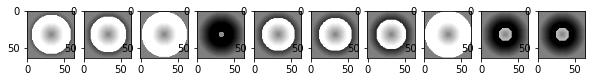

In [5]:
data = dataset.construct(nsamples, nrows, ncols, "circle")
X = data - data.mean(axis=0) # center data: same input data as PCA.

fig, axs = plt.subplots(1, 10, figsize=(10,1))
for (i, ax) in enumerate(axs):
    ax.imshow(tf.reshape(X[i], (nrows, ncols)), vmin=vmin, vmax=vmax)

### 2. Create model

In [4]:
encoder = keras.Sequential([keras.layers.Dense(units=ncomponents, input_shape=(nrows*ncols,), activation='linear', use_bias=False)])
decoder = keras.Sequential([keras.layers.Dense(units=nrows*ncols, input_shape=(ncomponents,), activation='linear', use_bias=False)])

lae = keras.Sequential([encoder, decoder])
lae.compile(loss='mse', optimizer='adam')

### 3. Train model

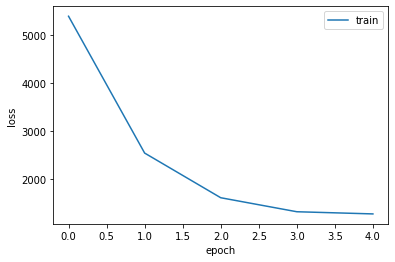

In [5]:
history = lae.fit(X, X, epochs=nepochs, batch_size=batch_size, verbose=0)
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

### 4. Transform into and from latent space

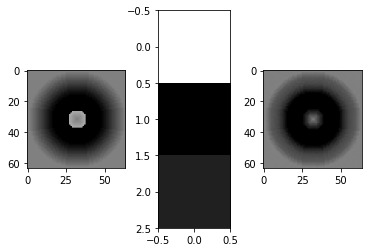

In [6]:
Z = encoder(X)
X_pred = decoder(Z)

fig, ax = plt.subplots(ncols=3, nrows=1)
ax[0].imshow(tf.reshape(X[expl_idx],(nrows, ncols)), vmin=vmin, vmax=vmax)
ax[1].imshow(tf.reshape(Z[expl_idx], (-1, 1)))
ax[2].imshow(tf.reshape(X_pred[expl_idx], (nrows, ncols)), vmin=vmin, vmax=vmax)

### 5. Interpolation in latent space

In [7]:
from ipywidgets import interactive
import ipywidgets as widgets

def f(**kwargs):
    z = np.array(list(kwargs.values()), dtype='float32')
    x_pred = decoder(z.reshape(1,-1))
    plt.figure(2)
    plt.imshow(tf.reshape(x_pred,(nrows, ncols)), vmin=vmin, vmax=vmax)

scores = Z[expl_idx]
sliders = {f"PC{i+1}": widgets.FloatSlider(min=tf.reduce_min(z),max=tf.reduce_max(z),value=score) 
           for (i,score), z in zip(enumerate(scores), tf.transpose(Z))}

interactive(f, **sliders)
ix_plot = interactive(f, **sliders)
output = ix_plot.children[-1]
output.layout.height = '250px'
ix_plot

interactive(children=(FloatSlider(value=2363.677490234375, description='PC1', max=2667.419189453125, min=-1972…

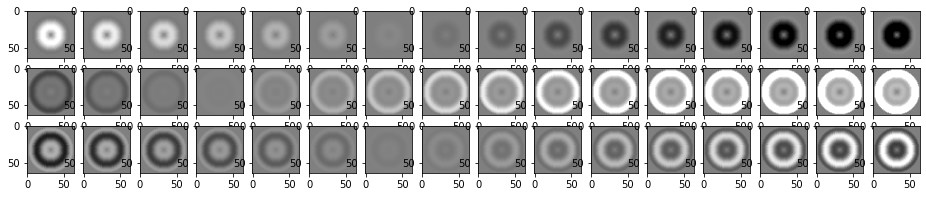

In [8]:
steps = 16
z_vars = [np.linspace(np.min(ax), np.max(ax), steps) for ax in tf.transpose(Z)] # interpolation range
fig, axs = plt.subplots(ncols=steps, nrows=ncomponents, figsize=(steps, ncomponents))

for i in range(ncomponents):
    for j in range(steps):
        z = np.zeros_like(Z[expl_idx]) # ! LAEs latent components are not uncorrelated
        z[i] = z_vars[i][j]
        x_pred = decoder.predict(z.reshape(1, -1))
        ax = list(axs.flat)[j+i*j] if ncomponents==1 else axs[i, j]
        ax.imshow(tf.reshape(x_pred, (nrows, ncols)), vmin=vmin, vmax=vmax)

### 6. Properties of LAE

Encoder weights:
 [[ 0.019  -0.0037 -0.033  ... -0.0168  0.0031  0.003 ]
 [ 0.0321 -0.0235  0.0355 ... -0.0084 -0.038  -0.0013]
 [-0.0125 -0.0082 -0.006  ... -0.002  -0.0348 -0.0176]]
Decoder weights:
 [[ 0.  0.  0. ...  0. -0. -0.]
 [-0. -0.  0. ...  0.  0. -0.]
 [ 0.  0. -0. ... -0. -0.  0.]]
===> W_enc ?= W_dec

Dot product of all encoder weights:
 [[ 2.32598  0.0601   0.09593]
 [ 0.0601   2.27492 -0.04385]
 [ 0.09593 -0.04385  2.31863]]
===> Weights are neither orthogonal nor unit norm.
Cov of latent activations:
 tf.Tensor(
[[ 2881650.  -1034715.  -1034240.7]
 [-1034715.   2905769.5  1277117.8]
 [-1034240.7  1277117.8  1696289.9]], shape=(3, 3), dtype=float32)
===> Latent components are heavily correlated.


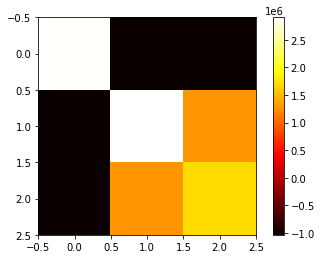

In [11]:
W_enc = np.round( lae.layers[0].get_weights()[0], 4 ).T
W_dec = np.round( lae.layers[1].get_weights()[0], 4 )

print("Encoder weights:\n", W_enc)
print("Decoder weights:\n", W_dec)
print("===> W_enc ?= W_dec\n")

pcs = encoder.weights[0]
I = (tf.transpose(pcs) @ pcs)
print("Dot product of all encoder weights:\n", np.round(I, 5))
print("===> Weights are neither orthogonal nor unit norm.")

fig, ax = plt.subplots()
Z = tf.subtract(Z, tf.reduce_mean(Z, axis=0))
Z_cov = (tf.transpose(Z) @ Z) / (nsamples-1)
print("Cov of latent activations:\n", Z_cov)
plt.imshow(Z_cov, cmap='hot')
plt.colorbar();
print("===> Latent components are heavily correlated.")

### 7. Calculate MSE

In [10]:
X_pred = lae.predict(X)
print("MSE: ", np.square(np.subtract(X, X_pred)).mean())

MSE:  1273.6544
